In [1]:
class Bot():
    def __init__(self,strategy) -> None:
        self.strategy=strategy
        if self.strategy=="kris":
            self.__history=["R"]
        if self.strategy=="mrugesh":
            self.__history=["R" for i in range(10)]
    
    def play(self,context):
        if self.strategy=="mrugesh":
            s=""
            for i in range(len(context)):
                s=s+self._mrugesh()
                self.update_history(context[i])
            return s
        elif self.strategy=="kris":
            s=""
            for i in range(len(context)):
                s=s+self._kris()
                self.update_history(context[i])
            return s

    def update_history(self,move):
        self.__history.append(move)

    def _mrugesh(self):
        last_ten=self.__history[-10:]
        most_frequent = max(set(last_ten), key=last_ten.count)

        ideal_response = {'P': 'S', 'R': 'P', 'S': 'R'}
        return ideal_response[most_frequent]
    
    def _kris(self):
        ideal_response = {'P': 'S', 'R': 'P', 'S': 'R'}
        return ideal_response[self.__history[-1]]

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random


# Создаем словарь символов
chars = sorted(set("RPS"))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

# Подготовка последовательности символов и меток
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[ch] for ch in seq]
    return torch.tensor(idxs, dtype=torch.long)

# Архитектура модели LSTM
class LSTMTextGenerator(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size):
        super(LSTMTextGenerator, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2output = nn.Linear(hidden_dim, output_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        output = self.hidden2output(lstm_out.view(len(sentence), -1))
        return output

# Подготовка данных и создание модели
EMBEDDING_DIM = 3
HIDDEN_DIM =  64
EPOCHS=2000
model = LSTMTextGenerator(EMBEDDING_DIM, HIDDEN_DIM, len(chars), len(chars))
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели

games_ahead=8
history="RPS"*games_ahead #initial history ,играет бот
bot=Bot(strategy="kris")

def get_antipos(context):
    ideal_response = {'P': 'S', 'R': 'P', 'S': 'R'}
    ans=""
    for i in context:
        ans=ans+ideal_response[i]
    return ans

loss_history=[]
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    #батча как такового нет ,есть количество игр которые наперед играет агент
    
    inputs = prepare_sequence(history[-games_ahead-1:-1], char_to_ix)
    targets = prepare_sequence(history[-games_ahead:], char_to_ix)  # Предсказание следующего символа
    
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = loss_function(outputs, targets)
    loss.backward()
    optimizer.step()
    total_loss = loss.item()


    #предсказали->перевернули-> записали ответ
    outputs_str=""
    for i in range(games_ahead):
        output_dist = F.softmax(outputs[i], dim=0)
        top_i = torch.argmax(output_dist).item()
        outputs_str += ix_to_char[top_i]
        

    history=history+bot.play(get_antipos(outputs_str))
    
    loss_history.append(loss.item())
    if (epoch+1) % 200 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')




Epoch 200, Loss: 0.5479005575180054
Epoch 400, Loss: 0.41191262006759644
Epoch 600, Loss: 0.3498115837574005
Epoch 800, Loss: 0.22835463285446167
Epoch 1000, Loss: 0.2097180187702179
Epoch 1200, Loss: 0.246157705783844
Epoch 1400, Loss: 0.2267121523618698
Epoch 1600, Loss: 0.2138199508190155
Epoch 1800, Loss: 0.2246926724910736
Epoch 2000, Loss: 0.21536511182785034


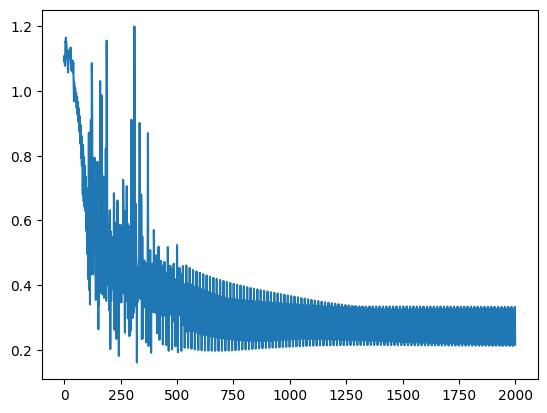

In [3]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot([i for i in range(EPOCHS)],loss_history)

In [4]:
def decode(x):
    _={"R":0,"P":1,"S":2}
    return _[x]

def encode(x):
    _={0:"R",1:"P",2:"S"}
    return _[x]

def decide_winner(x,y,decoded=True):
    if decoded:
        winning_situations = [[0, 2], [2, 1], [1, 0]]
        if [x, y] in winning_situations:
            return 1
        elif x == y:
            return 0
        else:
            return -1
    else:
        x,y=decode(x),decode(y)
        winning_situations = [[0, 2], [2, 1], [1, 0]]
        if [x, y] in winning_situations:
            return 1
        elif x == y:
            return 0
        else:
            return -1
        


# сыграем 1000 игр с полученной моделью

model.eval()
actual_history="RPSRPSRPS" #history of bot moves
generated=actual_history
hidden = None
last_player_move=get_antipos(generated[-1])

stats={"player_wins":0,"bot_wins":0,"tie":0}


for _ in range(1,1001):  
    input = prepare_sequence(actual_history[-8:], char_to_ix)
    output = model(input)
    output_dist = F.softmax(output[-1], dim=0)
    top_i = torch.argmax(output_dist).item()
    generated += ix_to_char[top_i]
    #предсказали->перевернули->записали ответ
    #последний ход бота в
    
    player_move=get_antipos(generated[-1])

    bot_move=bot.play(last_player_move)

    #print(f"Player: {player_move}",f"Bot:{bot_move}")
    bot.update_history(player_move)
    actual_history+=bot_move
    last_player_move=player_move

    if decide_winner(player_move,bot_move,decoded=False)==1:
        stats["player_wins"]+=1
    elif decide_winner(player_move,bot_move,decoded=False)==0:
        stats["tie"]+=1
    else:
        stats["bot_wins"]+=1
    
    if _%100==0:
        print(stats)
        print(f"winrate=={stats['player_wins']/_}")

#5000 epochs -8 games ahead 54% WR


{'player_wins': 26, 'bot_wins': 69, 'tie': 5}
winrate==0.26
{'player_wins': 54, 'bot_wins': 141, 'tie': 5}
winrate==0.27
{'player_wins': 81, 'bot_wins': 214, 'tie': 5}
winrate==0.27
{'player_wins': 108, 'bot_wins': 287, 'tie': 5}
winrate==0.27
{'player_wins': 135, 'bot_wins': 360, 'tie': 5}
winrate==0.27
{'player_wins': 163, 'bot_wins': 432, 'tie': 5}
winrate==0.27166666666666667
{'player_wins': 190, 'bot_wins': 505, 'tie': 5}
winrate==0.2714285714285714
{'player_wins': 217, 'bot_wins': 578, 'tie': 5}
winrate==0.27125
{'player_wins': 244, 'bot_wins': 651, 'tie': 5}
winrate==0.27111111111111114
{'player_wins': 272, 'bot_wins': 723, 'tie': 5}
winrate==0.272
